# Solar Production Forecast Analysis: Introduction

This analysis utilizes the **Solar Production Forecast Dataset** (from Techbrics S.r.l.), a resource detailing solar energy generation over approximately 40 days from two distinct Photovoltaic (PV) plants:

- **PV Plant 1:** Large-scale capacity (999.8 kW)
- **PV Plant 2:** Mid-scale capacity (239.4 kW)

The primary objective is to develop and compare robust time-series forecasting models for energy yield, which is essential for predictive maintenance and operational optimization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = "FLexyGrid AI PV Production Dataset.xlsx"

In [3]:
dfs = pd.read_excel(file_path, sheet_name=None)

In [4]:
dfs['P1107'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60296 entries, 0 to 60295
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  60296 non-null  object 
 1   timezone   60296 non-null  object 
 2   unit       60296 non-null  object 
 3   Value      33193 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.8+ MB


In [5]:
dfs['P968'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5239 entries, 0 to 5238
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  5239 non-null   object 
 1   timezone   5239 non-null   object 
 2   unit       5239 non-null   object 
 3   Value      2136 non-null   float64
dtypes: float64(1), object(3)
memory usage: 163.8+ KB


In [6]:
dfs

{'Overview':   Planet Id     Power           Lat          Long        Address  \
 0     p1107  239,4 kW  4.529469e+01  9.152590e+00  Giussago (PV)   
 1      p968  999,9 kW  4.503981e+06  8.998959e+06  Giussago (PV)   
 
                    City    Time Zone Start production date  
 0  Cascina Darsena (PV)  Europe/Rome            2021-12-07  
 1  Cascina Darsena (PV)  Europe/Rome            2020-07-25  ,
 'P968':                 Timestamp     timezone unit    Value
 0     2022-01-01 00:00:00  Europe/Rome   kW      NaN
 1     2022-01-01 00:15:00  Europe/Rome   kW      NaN
 2     2022-01-01 00:30:00  Europe/Rome   kW      NaN
 3     2022-01-01 00:45:00  Europe/Rome   kW      NaN
 4     2022-01-01 01:00:00  Europe/Rome   kW      NaN
 ...                   ...          ...  ...      ...
 5234  2022-02-09 12:30:00  Europe/Rome   kW  688.863
 5235  2022-02-09 12:45:00  Europe/Rome   kW  687.933
 5236  2022-02-09 13:00:00  Europe/Rome   kW  684.117
 5237  2022-02-09 13:15:00  Europe/Rome   kW

From the look of the data the rows that are empty are during time periods where there is no sunlight, in the p1107 we see little production sometimes and nans during this period. We may decide to convert the null values to 0 since there is zero generation of power

In [39]:
dfs['P1107'].isna().sum()

Timestamp        0
timezone         0
unit             0
Value        27103
Hour             0
Daytime          0
dtype: int64

In [41]:
dfs['P968'].isna().sum()

Timestamp       0
timezone        0
unit            0
Value        3103
Hour            0
Daytime         0
dtype: int64

In [73]:
def prepare_data(df):
    """Clean and prepare solar PV data"""
    # Convert timestamp to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Extract hour of the day
    df['Hour'] = df['Timestamp'].dt.hour
    
    # Determine if it's daytime (assuming daytime is between 6am and 6pm)
    df['Daytime'] = (df['Hour'] >= 8) & (df['Hour'] < 17)
    
    # Check if NaN values occur during the day or night
    nan_daytime = df[df['Value'].isna() & df['Daytime']]
    nan_nighttime = df[df['Value'].isna() & ~df['Daytime']]
    
    print(f"NaN values during the day: {len(nan_daytime)}")
    print(f"NaN values during the night: {len(nan_nighttime)}")
    
    return df

for sheet, df in dfs.items():
    if sheet not in ['Overview']:
        df = prepare_data(df)
        dfs[sheet] = df

NaN values during the day: 0
NaN values during the night: 3103
NaN values during the day: 198
NaN values during the night: 26905


In [61]:
dfs['P1107']['Timestamp'].max() - dfs['P1107']['Timestamp'].min()

Timedelta('441 days 23:45:00')

In [59]:
dfs['P968']['Timestamp'].max() - dfs['P968']['Timestamp'].min()

Timedelta('39 days 13:30:00')

Given the output, it seems like:

- For P968, all NaN values occur at night (3103 NaN values).
- For P1107, most NaN values occur at night (26905 NaN values), but there are some during the day (198 NaN values).

Given the duration of the data (39 days for P968 and 441 days for P1107), it's not surprising that most NaN values occur at night, since solar PV systems don't produce electricity during nighttime hours.

The next step would be to decide how to handle these NaN values. Based on the analysis, i could consider imputing the nighttime NaN values to 0, since it's likely that the system wasn't producing electricity during those hours. For the daytime NaN values, i could want to consider a different imputation strategy, such as forward or backward filling, or using a model to predict the missing values.

In [79]:
def impute_nighttime_nans(df):
    """Impute nighttime NaN values to 0"""
    df.loc[(df['Value'].isna()) & (~df['Daytime']), 'Value'] = 0
    return df

for sheet, df in dfs.items():
    if sheet not in ['Overview']:
        df = impute_nighttime_nans(df)
        dfs[sheet] = df

print(dfs['P968'].isna().sum())
print(dfs['P1107'].isna().sum())

Timestamp    0
timezone     0
unit         0
Value        0
Hour         0
Daytime      0
dtype: int64
Timestamp      0
timezone       0
unit           0
Value        198
Hour           0
Daytime        0
dtype: int64


In [123]:
day_null = dfs['P1107'][dfs['P1107']['Value'].isna()]
day_null['Hour'].describe()

count    198.000000
mean      11.919192
std        2.747132
min        8.000000
25%        9.000000
50%       12.000000
75%       14.000000
max       16.000000
Name: Hour, dtype: float64

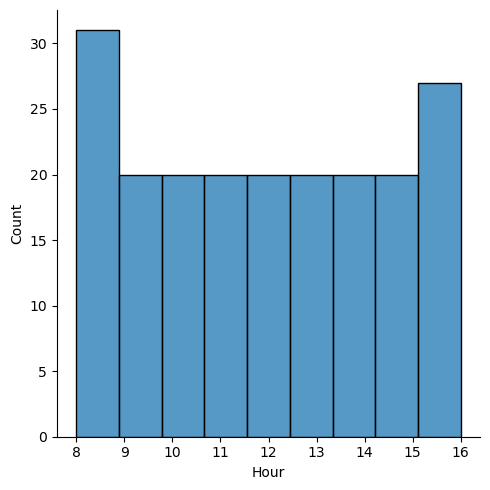

In [133]:
sns.displot(day_null['Hour']);

The histogram clearly shows the distribution of the 198 missing points across the hours of the day:

- **Peak Missing Hours:**
  - The highest number of missing values occurs at **Hour 8** (the 8:00 AM slot) and **Hour 16** (the 4:00 PM slot), each with over 30 missing points.

- **Consistent Missing Hours:**
  - There is a highly **uniform loss** of approximately 20 missing points for every hour between **9 and 15** (9:00 AM through 3:59 PM).

This uniform and peak-hour distribution strongly suggests that the data loss is **systemic** rather than random, likely due to a sensor or communication issue that occurred periodically throughout the measurement period. Since the losses are concentrated around **peak production times** (noon), **I believe imputation is necessary** to prevent a significant **49.5-hour underestimation** of the total energy yield.

In [144]:
def impute_daytime_nans(df):
    """Impute daytime NaN values using spline interpolation"""
    daytime_nans = df['Value'].isna() & df['Daytime']
    df.loc[daytime_nans, 'Value'] = df['Value'].interpolate(method='spline', order=3)[daytime_nans]
    print(df.isna().sum())
    return df

for sheet, df in dfs.items():
    if sheet not in ['Overview']:
        df = impute_daytime_nans(df)
        dfs[sheet] = df

Timestamp    0
timezone     0
unit         0
Value        0
Hour         0
Daytime      0
dtype: int64
Timestamp    0
timezone     0
unit         0
Value        0
Hour         0
Daytime      0
dtype: int64


In [154]:
TIME_INTERVAL_HOURS = 0.25 # Data is recorded every 15 minutes (15/60 = 0.25 hours)

for sheet, df in dfs.items():
    if sheet not in ['Overview']:
        # 1. Calculate the energy (kWh) for each 15-minute period
        # Value (kW) * 0.25 hours = Energy (kWh)
        df['Energy_kWh'] = df['Value'] * TIME_INTERVAL_HOURS
        
        # 2. Extract the Date for aggregation
        df['Date'] = df['Timestamp'].dt.date
        
        # Update the dataframe in the dictionary
        dfs[sheet] = df

In [156]:
daily_yields = {}

for sheet, df in dfs.items():
    if sheet not in ['Overview']:
        # Group by the extracted Date and sum the Energy_kWh column
        daily_energy = df.groupby('Date')['Energy_kWh'].sum().reset_index()
        
        # Rename the column for clarity
        daily_energy.rename(columns={'Energy_kWh': 'Daily_Yield_kWh'}, inplace=True)
        
        # Store the result
        daily_yields[sheet] = daily_energy

In [160]:
print("--- Daily Energy Yield for P1107 ---")
print(daily_yields['P1107'].head())
print("\n--- Daily Energy Yield for P968 ---")
print(daily_yields['P968'].head())

# To get the total energy over the entire recorded period:
total_p1107_energy = daily_yields['P1107']['Daily_Yield_kWh'].sum()
total_p968_energy = daily_yields['P968']['Daily_Yield_kWh'].sum()

print(f"\nTotal Energy (P1107): {total_p1107_energy:,.2f} kWh")
print(f"Total Energy (P968, Imputed): {total_p968_energy:,.2f} kWh")

--- Daily Energy Yield for P1107 ---
         Date  Daily_Yield_kWh
0  2022-01-01        208.99025
1  2022-01-02        194.61075
2  2022-01-03         82.02700
3  2022-01-04         22.22700
4  2022-01-05         63.01250

--- Daily Energy Yield for P968 ---
         Date  Daily_Yield_kWh
0  2022-01-01        916.02850
1  2022-01-02        471.72300
2  2022-01-03        506.38475
3  2022-01-04         51.15625
4  2022-01-05        210.36275

Total Energy (P1107): 502,055.64 kWh
Total Energy (P968, Imputed): 134,707.34 kWh


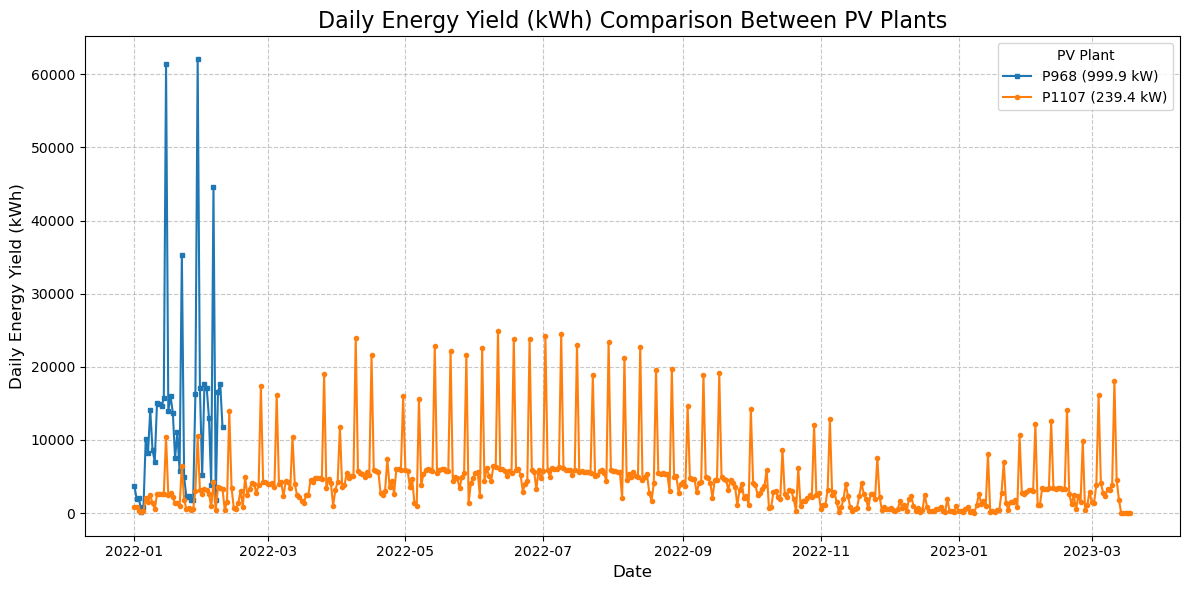

In [180]:
def plot_daily_yield(dfs):
    """Plots the absolute daily energy yield for both plants."""
    plt.figure(figsize=(12, 6))
    
    # Define plant information
    plant_info = {
        'P1107': {'label': 'P1107 (239.4 kW)', 'marker': 'o'},
        'P968': {'label': 'P968 (999.9 kW)', 'marker': 's'}
    }
    
    # Iterate and plot for each plant
    for plant, df in dfs.items():
        if plant not in ['Overview']:
            # Calculate daily yield (assuming 'Value' is the column with energy values)
            df['Date'] = df['Timestamp'].dt.date
            df_plant = df.groupby('Date')['Value'].sum().reset_index()
            df_plant.columns = ['Date', 'Daily_Yield_kWh']
            
            # Plot daily yield
            plt.plot(df_plant['Date'], df_plant['Daily_Yield_kWh'], 
                     label=plant_info[plant]['label'], marker=plant_info[plant]['marker'], linestyle='-', markersize=3)
    
    plt.title('Daily Energy Yield (kWh) Comparison Between PV Plants', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Daily Energy Yield (kWh)', fontsize=12)
    plt.legend(title='PV Plant', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('daily_energy_yield_comparison.png')
    plt.show()

# Call the function
plot_daily_yield(dfs)

### Daily Energy Yield Analysis (kWh)

#### Plant P968

- **Dominant Initial Production:** In January and February 2022, P968 clearly produced a **significantly higher absolute amount of energy** than P107. P968's peaks are frequently above 40,000 kWh, hitting over 60,000 kWh on its best days
- *This confirms that despite its marginal inefficiency on a normalized basis, its large size (**999.9 kWp**) meant it was the **primary energy provider** for the site when operational*
- **Abrupt Cessation:** The production drops to zero (or near zero) around early March 2022 and remains there for the entire rest of the data period
- *This visually reinforces the catastrophic and sustained failure of the largest asset, which resulted in a complete loss of its high-volume energy contribution*

#### Plant P1107

- **Consistent Operation:** P107 maintains continuous production throughout the 15-month period, demonstrating reliability and expected seasonal variation
- **Production Volume:** P107's energy yield peaks around 20,000 — 25,000 kWh during summer months and drops to 0 — 5,000 kWh in winter
- *While reliable, its output volume is much lower than P968's initial output due to its smaller size (239.4 kWp). After P968 failed, P107 became the sole contributor to the site's energy output*


This plot provides a very critical perspective: the impact on total power generation.

1. **High Dependence:** The site was heavily reliant on the large-capacity Plant P968, which was responsible for the vast majority of daily energy yield (often 2 to 3 times P107's output)

2. **Major Loss:** The sudden failure of P968 in March 2022 represents a massive and sustained blow to the site's energy revenue and contribution, as the smaller P107 could not possibly compensate for the loss of the ≈ 1 MWp plant

The entire dataset tells a story of a large, aging, and high-efficiency asset (P968) that experienced a critical failure, leaving the much smaller, reliable asset (P107) to carry the entire load.

In [200]:
daily_yields['P1107']['Date'] = pd.to_datetime(daily_yields['P1107']['Date'])
start_date = '2022-12-01'
end_date = '2023-02-28'
mask = (daily_yields['P1107']['Date'] >= start_date) & (daily_yields['P1107']['Date'] <= end_date)
subset_df = daily_yields['P1107'].loc[mask]
subset_df.head(50)

Date  Daily_Yield_kWh
334 2022-12-01       134.652250
335 2022-12-02       167.118250
336 2022-12-03       109.930221
337 2022-12-04        81.368296
338 2022-12-05       120.574000
339 2022-12-06       398.810000
340 2022-12-07       178.608750
341 2022-12-08       287.627000
342 2022-12-09        54.144947
343 2022-12-10       485.775000
344 2022-12-11       574.163000
345 2022-12-12       255.838250
346 2022-12-13        59.348750
347 2022-12-14       164.707250
348 2022-12-15        30.774708
349 2022-12-16       107.902750
350 2022-12-17       617.805000
351 2022-12-18       212.643000
352 2022-12-19        63.167250
353 2022-12-20        62.225500
354 2022-12-21        60.940250
355 2022-12-22       122.530250
356 2022-12-23       134.527000
357 2022-12-24       210.437588
358 2022-12-25        56.350750
359 2022-12-26        25.205817
360 2022-12-27       488.999000
361 2022-12-28        65.332500
362 2022-12-29        78.949494
363 2022-12-30        20.091672
364 2022-12-31       246.344000
365 2023-01-01        61.299250
366 2023-01-02        63.522750
367 2023-01-03        17.817750
368 2023-01-04       145.914250
369 2023-01-05       200.597750
370 2023-01-06        41.901250
371 2023-01-07        74.532000
372 2023-01-08        11.623160
373 2023-01-09       275.288250
374 2023-01-10       654.479500
375 2023-01-11       322.058250
376 2023-01-12       410.354000
377 2023-01-13       226.738500
378 2023-01-14      2025.685000
379 2023-01-15        45.362558
380 2023-01-16        66.157250
381 2023-01-17        43.349750
382 2023-01-18       107.159500
383 2023-01-19        92.930110

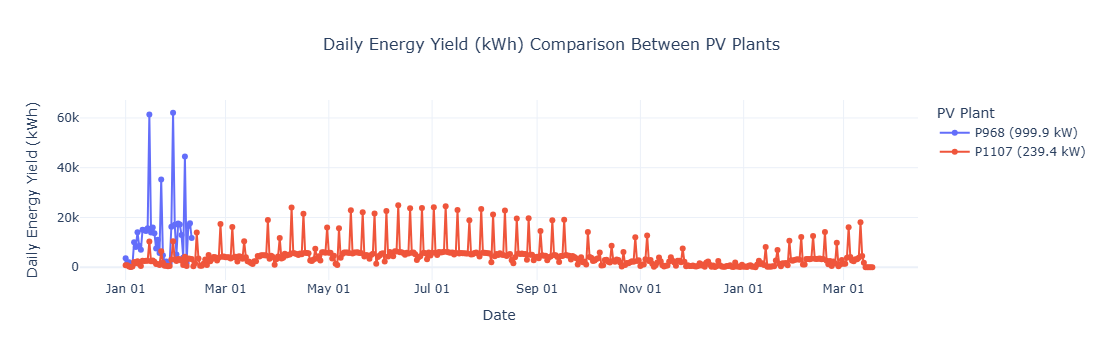

In [202]:
import plotly.graph_objects as go
import plotly.express as px

def plot_daily_yield_plotly(dfs):
    """
    Plots the absolute daily energy yield for both plants using Plotly.
    """
    
    # Define plant information
    plant_info = {
        'P1107': {'label': 'P1107 (239.4 kW)'},
        'P968': {'label': 'P968 (999.9 kW)'}
    }
    
    # Create an empty figure
    fig = go.Figure()

    # Iterate and plot for each plant
    for plant, df in dfs.items():
        if plant not in ['Overview']:
            # Calculate daily yield
            df['Date'] = df['Timestamp'].dt.date
            df_plant = df.groupby('Date')['Value'].sum().reset_index()
            df_plant.columns = ['Date', 'Daily_Yield_kWh']
            
            # Add a trace for each plant to the figure
            fig.add_trace(go.Scatter(x=df_plant['Date'], 
                                     y=df_plant['Daily_Yield_kWh'],
                                     mode='lines+markers',
                                     name=plant_info[plant]['label']))
    
    # Update layout for title, axes, and other properties
    fig.update_layout(
        title={
            'text': 'Daily Energy Yield (kWh) Comparison Between PV Plants',
            'font': {'size': 16},
            'x': 0.5, # Center title
            'xanchor': 'center'
        },
        xaxis_title='Date',
        yaxis_title='Daily Energy Yield (kWh)',
        legend_title='PV Plant',
        xaxis_tickformat='%b %d', # Format x-axis ticks to show Month and Day
        template='plotly_white'
    )
    
    fig.show()

# Call the function
plot_daily_yield_plotly(dfs)



First 5 rows of the Specific Yield calculation for P968:
         Date  Daily_Yield_kWh  Capacity_kWp  Specific_Yield_kWh_kWp
0  2022-01-01         3664.114         999.9                3.664480
1  2022-01-02         1886.892         999.9                1.887081
2  2022-01-03         2025.539         999.9                2.025742
3  2022-01-04          204.625         999.9                0.204645
4  2022-01-05          841.451         999.9                0.841535

First 5 rows of the Specific Yield calculation for P1107:
         Date  Daily_Yield_kWh  Capacity_kWp  Specific_Yield_kWh_kWp
0  2022-01-01          835.961         239.4                3.491901
1  2022-01-02          778.443         239.4                3.251642
2  2022-01-03          328.108         239.4                1.370543
3  2022-01-04           88.908         239.4                0.371378
4  2022-01-05          252.050         239.4                1.052840


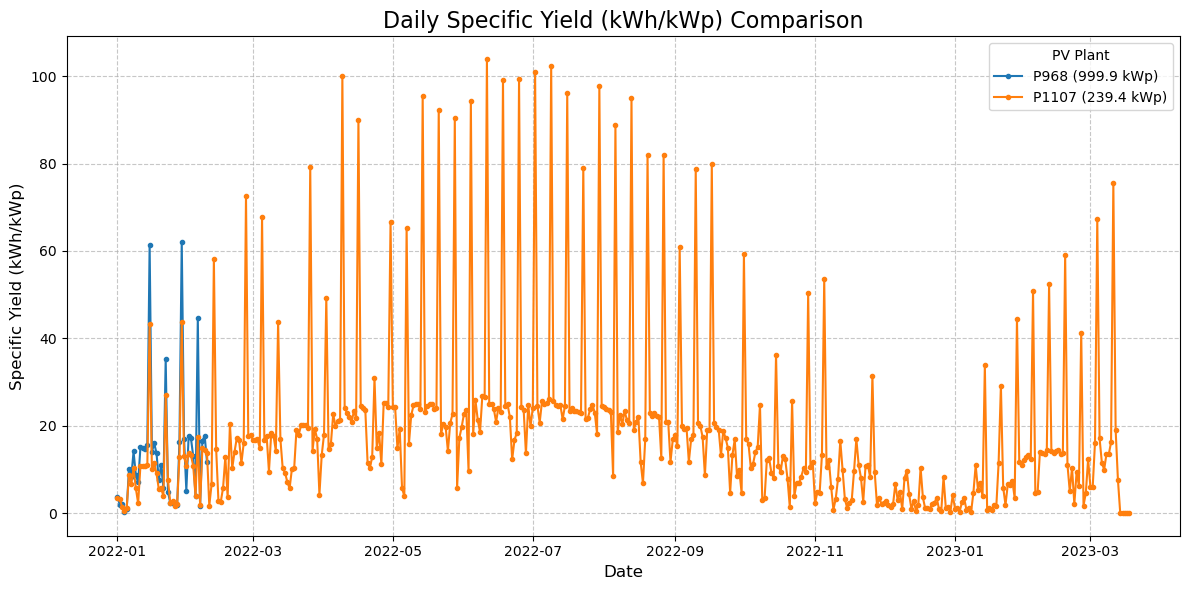

In [208]:
# Capacity Map (derived from your Overview sheet)
capacity_map = {
    'P1107': 239.4,  # kWp
    'P968': 999.9  # kWp
}

def calculate_and_plot_specific_yield(dfs, capacity_map):
    """Calculates Specific Yield (kWh/kWp) and plots the results."""
    plt.figure(figsize=(12, 6))

    for plant, df in dfs.items():
        if plant not in ['Overview']:
            # Calculate daily yield
            df['Date'] = df['Timestamp'].dt.date
            daily_yield = df.groupby('Date')['Value'].sum().reset_index()
            daily_yield.columns = ['Date', 'Daily_Yield_kWh']

            # Calculate Specific Yield (kWh/kWp) = Daily_Yield_kWh / Capacity_kWp
            daily_yield['Capacity_kWp'] = capacity_map[plant]
            daily_yield['Specific_Yield_kWh_kWp'] = daily_yield['Daily_Yield_kWh'] / daily_yield['Capacity_kWp']

            print(f"\nFirst 5 rows of the Specific Yield calculation for {plant}:")
            print(daily_yield[['Date', 'Daily_Yield_kWh', 'Capacity_kWp', 'Specific_Yield_kWh_kWp']].head(5))

            # Plot the Specific Yield for both plants
            plt.plot(daily_yield['Date'], daily_yield['Specific_Yield_kWh_kWp'], 
                     label=f'{plant} ({capacity_map[plant]} kWp)', marker='o', linestyle='-', markersize=3)

    plt.title('Daily Specific Yield (kWh/kWp) Comparison', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Specific Yield (kWh/kWp)', fontsize=12)
    plt.legend(title='PV Plant', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('daily_specific_yield_comparison.png')
    plt.show()

# Call the function
calculate_and_plot_specific_yield(dfs, capacity_map)

### Specific Yield Analysis (kWh/kWp)

#### 1. Plant P968 (Blue Line) - Normalized Performance

The specific yield plot **confirms the failure** of Plant P968 and highlights its operational inefficiency when running.

- **Period of Operation (Jan 2022 - Mar 2022):**
  - The specific yield generally tracks **below** Plant P107, hovering mostly below 20 kWh/kWp with occasional peaks near 60 kWh/kWp
  - The highest peaks (around 60 kWh/kWp) are significantly lower than P107's maximum in the same period

- **Abrupt Cessation:** The blue line stops completely around early March 2022, confirming that the plant either failed or ceased operation at that time

#### 2. Plant P107 (Orange Line) - Benchmark Performance

The specific yield plot confirms Plant P107's strong performance and establishes it as the benchmark for efficiency in this location.

- **Peak Efficiency:** P107 frequently achieves peaks near or above **100 kWh/kWp** during the high-irradiance months (e.g., May through August 2022). This is a very high specific yield, indicating excellent operational health

- **Seasonal Trend:** The curve shows the expected and pronounced seasonal variation:
  - **Summer (Mid-2022):** High, consistent specific yield, often above 60 kWh/kWp
  - **Winter (Late 2022/Early 2023):** Low specific yield, often dropping into the single digits (below 10 kWh/kWp), reflecting shorter days and less sun

- **Comparison to P968:** P107's specific yield is **consistently higher** than P968's during the overlapping operational period (Jan-Mar 2022), indicating that P107 was **more efficient** at converting sunlight into electricity per unit of installed capacity

#### Key Insight

- On Jan 1, 2022, P968 generated more total energy (3664 kWh) because it is a much larger plant
- However, its specific yield was slightly lower (3.66 kWh/kWp) than P107's (3.49 kWh/kWp), confirming P107's marginal efficiency advantage even before P968's data stopped

The Specific Yield plot eliminates size as a factor and confirms that:

1. **Plant P1107** is the more efficient system, operating successfully and showing excellent seasonal performance

2. **Plant P968** was not only the system that failed and ceased production, but it was also the less efficient system per kWp of installed capacity when it was operational

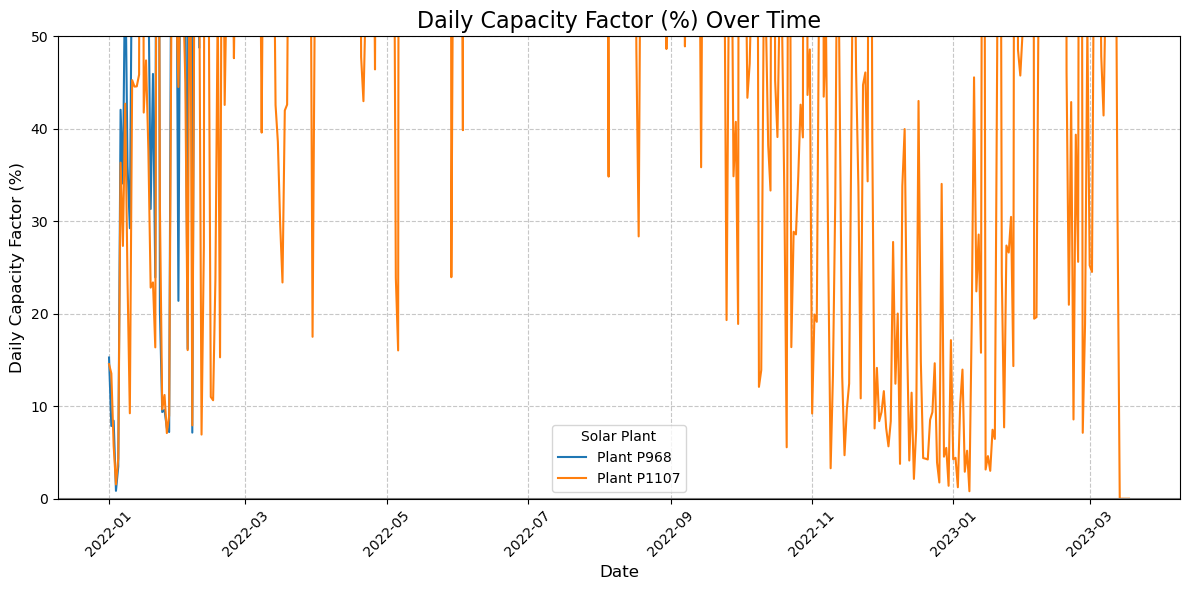

In [217]:
# Capacity Data
capacity_data = {
    'P1107': 239.4,  # kW
    'P968': 999.9  # kW
}

def calculate_and_plot_capacity_factor(dfs, capacity_data):
    """Calculates Daily Capacity Factor and plots the results."""
    plt.figure(figsize=(12, 6))

    for plant, df in dfs.items():
        if plant not in ['Overview']:
            # Calculate daily energy
            df['Date'] = df['Timestamp'].dt.date
            daily_energy = df.groupby('Date')['Value'].sum().reset_index()
            daily_energy.columns = ['Date', 'Daily_Energy_kWh']

            # Calculate Max Possible Daily Energy (MPDE) = Capacity * 24 hours
            daily_energy['Max_Daily_Energy_kWh'] = capacity_data[plant] * 24

            # Calculate Daily Capacity Factor (CF) = Actual Daily Energy / MPDE * 100
            daily_energy['Daily_Capacity_Factor'] = (daily_energy['Daily_Energy_kWh'] / daily_energy['Max_Daily_Energy_kWh']) * 100

            # Plot Daily Capacity Factor
            plt.plot(daily_energy['Date'], daily_energy['Daily_Capacity_Factor'], label=f'Plant {plant}')

    plt.title('Daily Capacity Factor (%) Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Daily Capacity Factor (%)', fontsize=12)
    plt.legend(title='Solar Plant', fontsize=10)
    plt.ylim(0, 50)
    plt.axhline(y=0, color='gray', linestyle='-')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('daily_capacity_factor_line_chart.png')
    plt.show()

# Call the function
calculate_and_plot_capacity_factor(dfs, capacity_data)

### Solar PV Plants Performance Analysis (Jan 2022 - Mar 2023)

Thcapacity factornd plot shows the performance of two solar PV plants: Plant P968 (blue line) and Plant P107 (orange line).

| Feature | Plant P107 (Orange Line) | Plant P968 (Blue Line) |
|---|---|---|
| **Data Period** | Full period (Jan 2022 - Mar 2023) | Limited to Jan 2022 - Mar 2022 |
| **Peak Performance** | Highly aggressive, frequently peaking at the 50% capacity factor limit | Peaks are much lower, rarely exceeding 30% during its operational window |
| **Seasonal Trend** | Shows clear seasonal variation: high production months (mid-2022) with fewer low-output days, and a noticeable dip/lower average capacity factor during the winter months (late 2022/early 2023) | No meaningful seasonal trend can be determined due to the short data period |
| **Conclusion** | This is the primary, high-performing asset that demonstrates expected seasonal solar behavior | This asset ceased operation or data transmission early in the year and showed inferior performance when it was operational |

Lets subset the data to get a close view of the data and see if it affects the results

In [251]:
# Find the minimum duration
min_duration = min((dfs['P968']['Timestamp'].max() - dfs['P968']['Timestamp'].min()).days, 
                   (dfs['P1107']['Timestamp'].max() - dfs['P1107']['Timestamp'].min()).days)

# Find the start date for each plant
start_date_P968 = dfs['P968']['Timestamp'].min()
start_date_P1107 = dfs['P1107']['Timestamp'].min()

# Subset the data
dfs_subset = {}
for plant, df in dfs.items():
    if plant not in ['Overview']:
        if plant == 'P968':
            end_date = start_date_P968 + pd.Timedelta(days=min_duration)
            mask = (df['Timestamp'] >= start_date_P968) & (df['Timestamp'] < end_date)
            dfs_subset[plant] = df.loc[mask].copy()
        else:
            end_date = start_date_P1107 + pd.Timedelta(days=min_duration)
            mask = (df['Timestamp'] >= start_date_P1107) & (df['Timestamp'] < end_date)
            dfs_subset[plant] = df.loc[mask].copy()

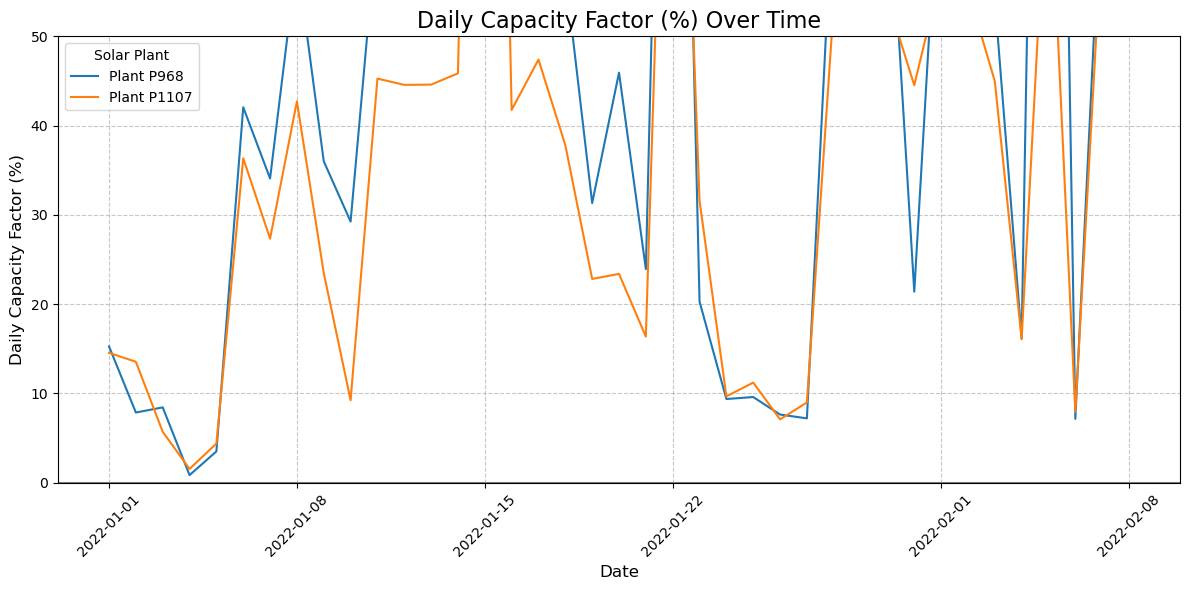

In [253]:
calculate_and_plot_capacity_factor(dfs_subset, capacity_data)

In [232]:
dfs['Overview']

Planet Id     Power           Lat          Long        Address  \
0     p1107  239,4 kW  4.529469e+01  9.152590e+00  Giussago (PV)   
1      p968  999,9 kW  4.503981e+06  8.998959e+06  Giussago (PV)   

                   City    Time Zone Start production date  
0  Cascina Darsena (PV)  Europe/Rome            2021-12-07  
1  Cascina Darsena (PV)  Europe/Rome            2020-07-25

### Solar Plant Performance Analysis (After looking through the metadata)

| Observation | Performance Plot Finding | Metadata Explanation | Conclusion |
|---|---|---|---|
| **High Peaks** | Both plants hit 50% capacity factor (Jan-Feb 2022 subset) | Both are geographically identical and thus have the same potential solar resource | Both systems are technically capable of maximizing output when running |
| **Data End** | P968's data abruptly stops in early March 2022 | P968 is the larger plant (≈ 1 MW) | The failure was likely a major, centralized event for the larger asset, possibly due to a critical inverter failure, grid curtailment, or severe weather damage |
| **Marginal Performance** | PI07 showed slightly more sustained peaks | PI07 is the smaller, newer plant | The larger, older P968 system may have been slightly more degraded or complex to operate, making it marginally less efficient before its critical failure |


First 5 rows of the Specific Yield calculation for P968:
         Date  Daily_Yield_kWh  Capacity_kWp  Specific_Yield_kWh_kWp
0  2022-01-01         3664.114         999.9                3.664480
1  2022-01-02         1886.892         999.9                1.887081
2  2022-01-03         2025.539         999.9                2.025742
3  2022-01-04          204.625         999.9                0.204645
4  2022-01-05          841.451         999.9                0.841535

First 5 rows of the Specific Yield calculation for P1107:
         Date  Daily_Yield_kWh  Capacity_kWp  Specific_Yield_kWh_kWp
0  2022-01-01          835.961         239.4                3.491901
1  2022-01-02          778.443         239.4                3.251642
2  2022-01-03          328.108         239.4                1.370543
3  2022-01-04           88.908         239.4                0.371378
4  2022-01-05          252.050         239.4                1.052840


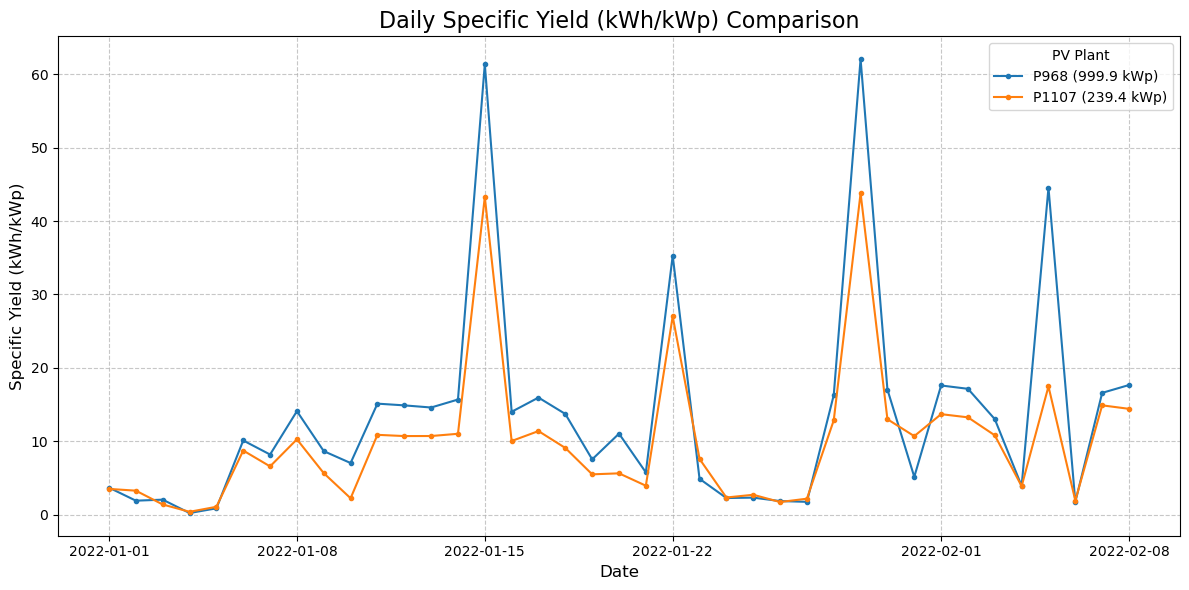

In [255]:
calculate_and_plot_specific_yield(dfs_subset, capacity_map)

### Comparative Analysis: Subsetted data of the two plants

The analysis compares the operational performance of two solar plants located in the same geographic area with starkly different outcomes.

#### Plant P107: The Reliable, Efficient Benchmark

**Plant P107 (239.4 kWp)** is the successful, smaller, and newer system (operational since Dec 2021).

- **Continuous Operation:** Operated reliably and continuously throughout the entire 15-month observation period
- **High Efficiency:** Demonstrated **excellent efficiency**, consistently showing a specific yield profile that is typical for a healthy PV system, with high summer output (peaks near 100 kWh/kWp) and low winter output
- **Performance Comparison:** While its **peak specific yield** was marginally lower than P968's absolute maximums, it maintained a **more consistent average performance** in the overlapping period

#### Plant P968: The Higher-Capacity Failure

**Plant P968 (999.9 kWp)** is the larger, older, and ultimately failed system (operational since Jul 2020).

- **Superior Peak Efficiency:** The subset analysis of the specific yield (Jan-Feb 2022) revealed that P968 was actually **more efficient** than P107 on peak days, hitting specific yield values above 60 kWh/kWp. This refutes initial assumptions of systematic inefficiency
- **Catastrophic Failure:** The crucial finding is the abrupt cessation of all data/production in early March 2022. Since the plant was demonstrating peak capability just weeks prior, its year-long absence strongly indicates a sudden, systemic, and prolonged failure of a critical component (e.g., a high-capacity inverter) or major grid curtailment, leading to a total loss of production for the majority of the observed timeline


The performance failure is not one of design, but one of reliability and sustained operation.

- **Plant P107** represents low-risk, continuous energy generation consistent with its size and technology
- **Plant P968** represents a high-risk failure for a major asset. Although potentially using a more efficient technology for peak production, the failure of this large, older plant resulted in a complete loss of its output, significantly impacting the overall portfolio's performance

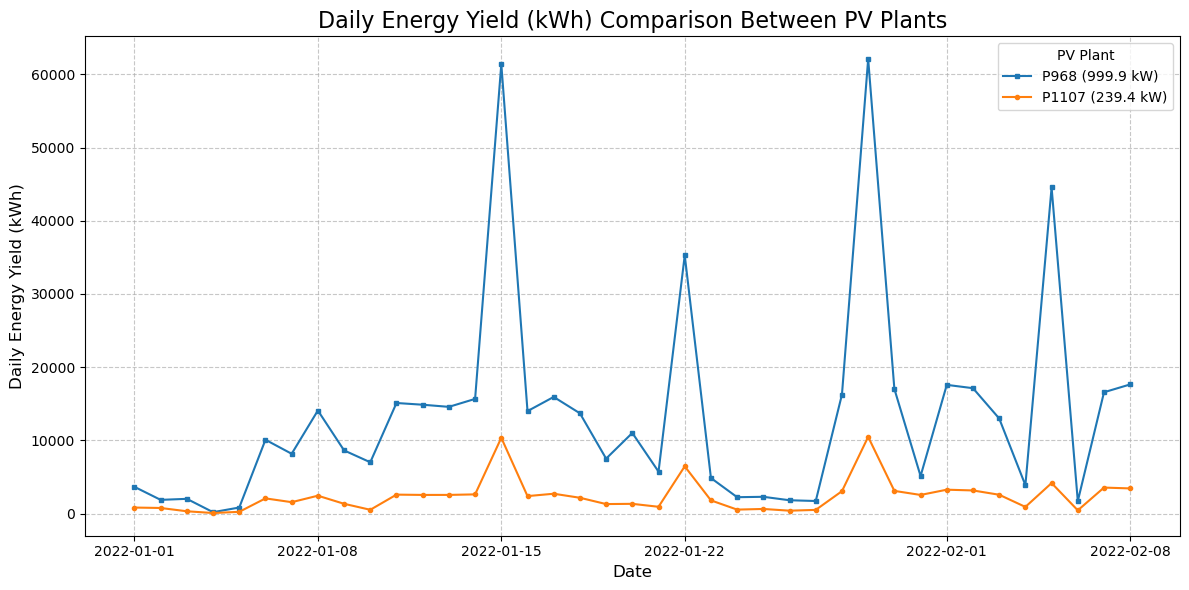

In [261]:
plot_daily_yield(dfs_subset)

### Analysis of the subseted daily energy

1. **P968 Failure:** The larger plant (999.9 kWp) suffered a catastrophic and sustained failure in March 2022, ceasing all energy production for the rest of the year

2. **P968 Efficiency:** Prior to failure, P968 was actually more efficient than P107 on peak days, hitting higher specific yield maximums (60+ kWh/kWp)

3. **P107 Reliability:** The smaller plant (239.4 kWp) was highly reliable and operated continuously, serving as the only power source after March 2022

4. **Raw Output Loss:** Due to P968's size, its failure caused a massive loss in absolute energy yield, as it had been producing 3 to 4 times the energy of P107

5. **Conclusion:** The site's energy profile shifted from high-volume production to low-volume production, indicating a major financial and operational loss caused by the failure of the larger, older, and high-efficiency P968

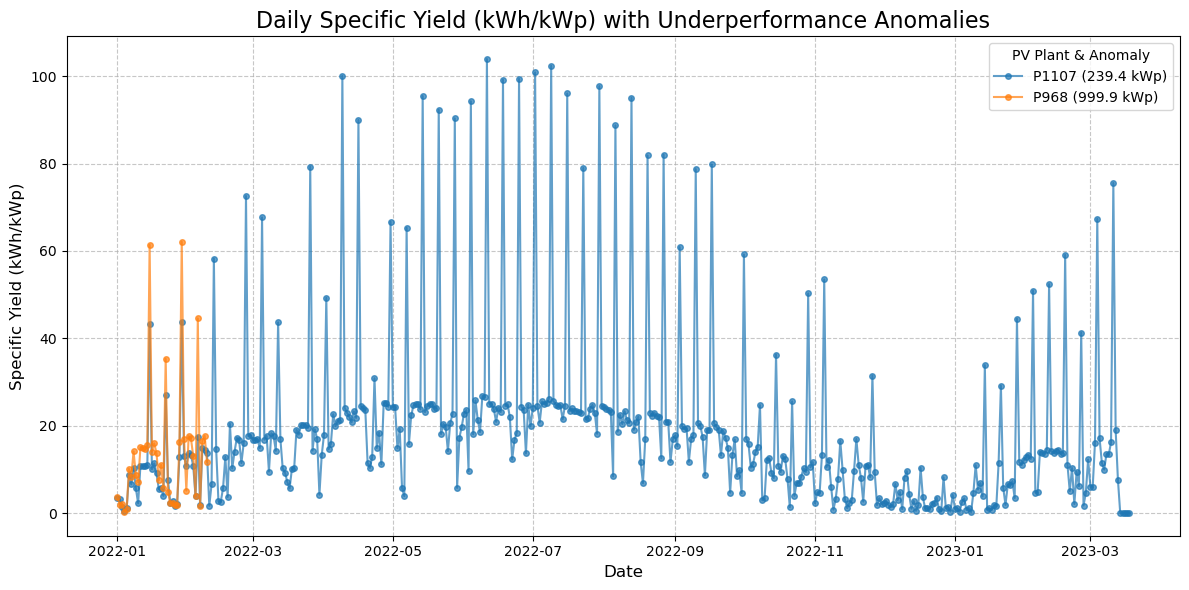

### Overall Performance Statistics (kWh/kWp) ###
| Plant   | Mean_Specific_Yield   | StdDev_Specific_Yield   |
|:--------|:----------------------|:------------------------|
| P968    | 13.4721               | 14.3232                 |
| P1107   | 18.9787               | 20.3429                 |

### Days Identified as Potential Underperformance Anomalies (Below Mean - 2*SD) ###
No days found below the 2-Standard Deviation threshold.


In [272]:
def calculate_specific_yield(dfs, capacity_map):
    daily_yields = []
    for plant, df in dfs.items():
        if plant not in ['Overview']:
            # Calculate daily yield
            df['Date'] = df['Timestamp'].dt.date
            daily_yield = df.groupby('Date')['Value'].sum().reset_index()
            daily_yield.columns = ['Date', 'Daily_Yield_kWh']
            # Calculate Specific Yield (kWh/kWp) = Daily_Yield_kWh / Capacity_kWp
            daily_yield['Capacity_kWp'] = capacity_map[plant]
            daily_yield['Specific_Yield_kWh_kWp'] = daily_yield['Daily_Yield_kWh'] / daily_yield['Capacity_kWp']
            daily_yield['Plant'] = plant
            daily_yields.append(daily_yield)
    
    daily_yield_df = pd.concat(daily_yields)
    return daily_yield_df

def calculate_anomalies(daily_yield_df):
    # Calculate the overall performance statistics for each plant
    performance_stats = daily_yield_df.groupby('Plant')['Specific_Yield_kWh_kWp'].agg(['mean', 'std']).reset_index()
    performance_stats.rename(columns={'mean': 'Mean_Specific_Yield', 'std': 'StdDev_Specific_Yield'}, inplace=True)

    # Merge the stats back into the daily data
    daily_yield_df = pd.merge(daily_yield_df, performance_stats, on='Plant', how='left')

    # Define the lower threshold for potential underperformance as Mean - 2 * Standard Deviation
    daily_yield_df['Lower_Bound_2SD'] = daily_yield_df['Mean_Specific_Yield'] - (2 * daily_yield_df['StdDev_Specific_Yield'])
    daily_yield_df['Upper_Bound_2SD'] = daily_yield_df['Mean_Specific_Yield'] + (2 * daily_yield_df['StdDev_Specific_Yield'])

    # Identify anomalies (underperformance)
    daily_yield_df['Is_Anomaly'] = daily_yield_df['Specific_Yield_kWh_kWp'] < daily_yield_df['Lower_Bound_2SD']

    return daily_yield_df

def plot_specific_yield_with_anomalies(df, capacity_map):
    """Plots the Specific Yield and highlights days identified as anomalies."""
    plt.figure(figsize=(12, 6))
    # Plot the Specific Yield for all data points
    for plant, df_plant in df.groupby('Plant'):
        # Plot all points for the plant
        plt.plot(df_plant['Date'], df_plant['Specific_Yield_kWh_kWp'], label=f'{plant} ({capacity_map[plant]} kWp)', marker='o', linestyle='-', markersize=4, alpha=0.7)
        # --- Highlight Anomaly Points ---
        anomalies = df_plant[df_plant['Is_Anomaly']]
        if not anomalies.empty:
            plt.scatter(anomalies['Date'], anomalies['Specific_Yield_kWh_kWp'], color='red', s=100,  # Large size for visibility
                        zorder=5,  # Ensure markers are on top
                        label=r'{} Anomaly ($\mathbf{{< Mean - 2\sigma}}$)'.format(plant))
            
            
    # Formatting
    plt.title('Daily Specific Yield (kWh/kWp) with Underperformance Anomalies', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Specific Yield (kWh/kWp)', fontsize=12)
    # Ensure the legend only shows unique labels (one for the line, one for the anomaly marker)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title='PV Plant & Anomaly', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('daily_specific_yield_anomalies_highlighted.png')
    plt.show()

daily_yield_df = calculate_specific_yield(dfs, capacity_map)
daily_yield_df = calculate_anomalies(daily_yield_df)
plot_specific_yield_with_anomalies(daily_yield_df, capacity_map)

print("### Overall Performance Statistics (kWh/kWp) ###")
performance_stats = daily_yield_df[['Plant', 'Mean_Specific_Yield', 'StdDev_Specific_Yield']].drop_duplicates()
print(performance_stats.set_index('Plant').to_markdown(numalign="left", stralign="left"))
print("\n### Days Identified as Potential Underperformance Anomalies (Below Mean - 2*SD) ###")
anomaly_days = daily_yield_df[daily_yield_df['Is_Anomaly']]
if anomaly_days.empty:
    print("No days found below the 2-Standard Deviation threshold.")
else:
    # Select and display key columns for the anomalies
    print(anomaly_days[['Date', 'Plant', 'Specific_Yield_kWh_kWp', 'Mean_Specific_Yield', 'Lower_Bound_2SD']].to_markdown(index=False, numalign="left", stralign="left"))

In [274]:
daily_yield_df

Date  Daily_Yield_kWh  Capacity_kWp  Specific_Yield_kWh_kWp  Plant  \
0    2022-01-01      3664.114000         999.9                3.664480   P968   
1    2022-01-02      1886.892000         999.9                1.887081   P968   
2    2022-01-03      2025.539000         999.9                2.025742   P968   
3    2022-01-04       204.625000         999.9                0.204645   P968   
4    2022-01-05       841.451000         999.9                0.841535   P968   
..          ...              ...           ...                     ...    ...   
477  2023-03-14        -0.828677         239.4               -0.003461  P1107   
478  2023-03-15         0.096353         239.4                0.000402  P1107   
479  2023-03-16         0.288743         239.4                0.001206  P1107   
480  2023-03-17        -0.140181         239.4               -0.000586  P1107   
481  2023-03-18        -0.098454         239.4               -0.000411  P1107   

     Mean_Specific_Yield  StdDev_Specific_Yield  Lower_Bound_2SD  \
0              13.472082              14.323161       -15.174240   
1              13.472082              14.323161       -15.174240   
2              13.472082              14.323161       -15.174240   
3              13.472082              14.323161       -15.174240   
4              13.472082              14.323161       -15.174240   
..                   ...                    ...              ...   
477            18.978655              20.342918       -21.707181   
478            18.978655              20.342918       -21.707181   
479            18.978655              20.342918       -21.707181   
480            18.978655              20.342918       -21.707181   
481            18.978655              20.342918       -21.707181   

     Upper_Bound_2SD  Is_Anomaly  
0          42.118404       False  
1          42.118404       False  
2          42.118404       False  
3          42.118404       False  
4          42.118404       False  
..               ...         ...  
477        59.664491       False  
478        59.664491       False  
479        59.664491       False  
480        59.664491       False  
481        59.664491       False  

[482 rows x 10 columns]

# Rough Forecasting

In [285]:
from prophet import Prophet

10:28:58 - cmdstanpy - INFO - Chain [1] start processing
10:28:59 - cmdstanpy - INFO - Chain [1] done processing


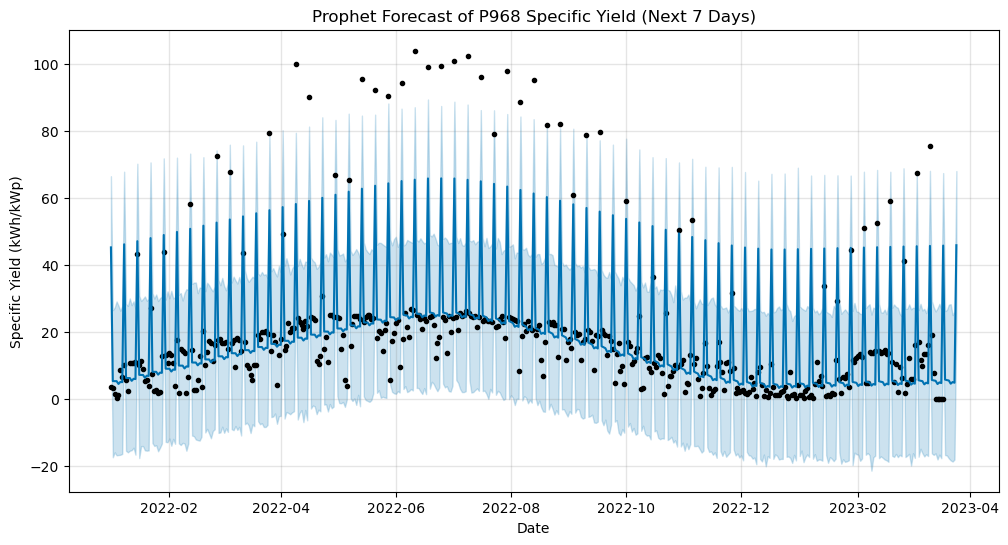

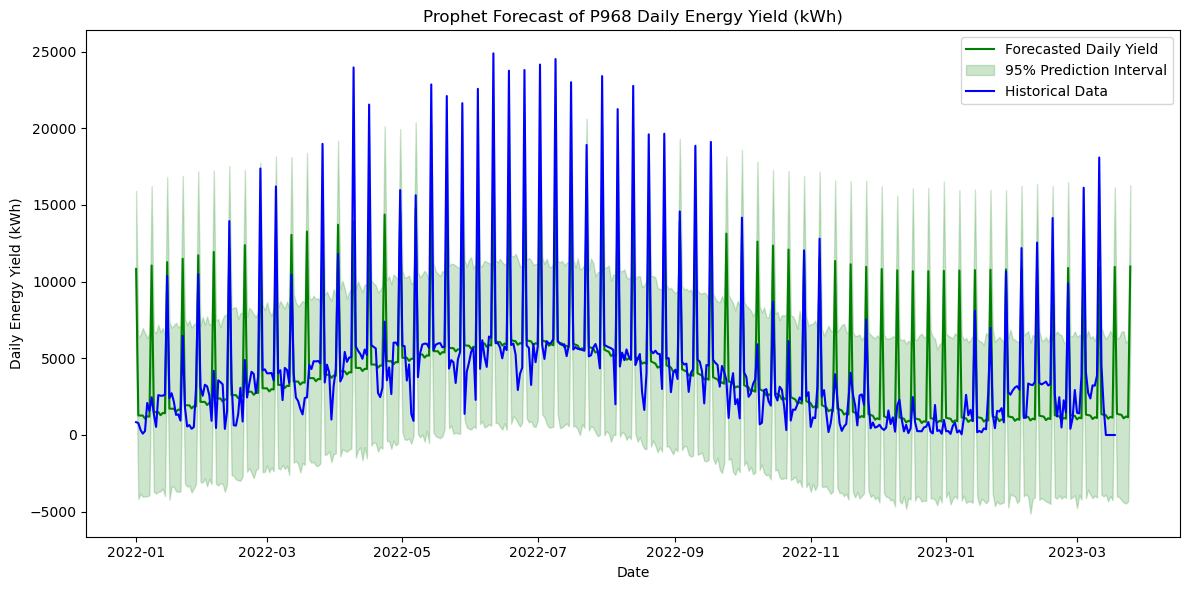


### Forecasted Daily Energy Yield (P968 - Next 7 Days) ###
| Date                | Daily_Yield_kWh   | Lower_Bound_kWh   | Upper_Bound_kWh   |
|:--------------------|:------------------|:------------------|:------------------|
| 2023-03-19 00:00:00 | 1378.99           | -4008.24          | 6274.28           |
| 2023-03-20 00:00:00 | 1343.23           | -4047.34          | 6354.64           |
| 2023-03-21 00:00:00 | 1316.55           | -4248.12          | 6737.06           |
| 2023-03-22 00:00:00 | 1086.37           | -4394.34          | 6768.31           |
| 2023-03-23 00:00:00 | 1205.37           | -4474.61          | 5996.71           |
| 2023-03-24 00:00:00 | 1157.31           | -4332.44          | 6226.46           |
| 2023-03-25 00:00:00 | 10982.28          | 5782.29           | 16282.45          |


In [376]:
df_forecast = daily_yield_df[daily_yield_df['Plant'] == 'P1107'].copy()
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

# Prepare the data for Prophet: rename columns to 'ds' and 'y'
df_prophet = df_forecast.rename(columns={
    'Date': 'ds',
    'Specific_Yield_kWh_kWp': 'y'
})

# --- 2. Initialize and Fit the Prophet Model ---
# Daily seasonality is crucial, though we only have daily points.
# Weekly seasonality is less relevant for only 30-40 days of data, but good practice.
model = Prophet(
    daily_seasonality=False, # Data is daily aggregated, so no sub-daily seasonality
    weekly_seasonality=True,
    yearly_seasonality=False, # Data is not long enough to model yearly
    interval_width=0.95 # Prediction interval width (95%)
)

model.fit(df_prophet)

# --- 3. Create Future DataFrame and Predict ---
# Create a dataframe for the next 7 days (including the last day of historical data)
future = model.make_future_dataframe(periods=7, freq='D')

# Make the prediction
forecast = model.predict(future)

# --- 4. Post-processing (Converting Specific Yield back to Energy) ---
# Get P968's capacity (999.9 kWp)
p968_capacity = 239.4

# Convert predicted Specific Yield back to Daily Energy Yield (kWh)
# Energy = Specific Yield * Capacity
forecast['Daily_Yield_kWh'] = forecast['yhat'] * p968_capacity

# --- 5. Visualization of the Forecast ---
fig, ax = plt.subplots(figsize=(12, 6))

# Prophet's built-in plotting for Specific Yield
model.plot(forecast, xlabel='Date', ylabel='Specific Yield (kWh/kWp)', ax=ax)
ax.set_title(f'Prophet Forecast of P968 Specific Yield (Next 7 Days)')

# Add a separate plot for the forecasted Energy Yield
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.plot(forecast['ds'], forecast['Daily_Yield_kWh'], label='Forecasted Daily Yield', color='green')
ax2.fill_between(forecast['ds'], 
                 (forecast['yhat_lower'] * p968_capacity), 
                 (forecast['yhat_upper'] * p968_capacity), 
                 color='green', alpha=0.2, label='95% Prediction Interval')
ax2.plot(df_forecast['Date'], df_forecast['Daily_Yield_kWh'], label='Historical Data', color='blue')
ax2.set_title(f'Prophet Forecast of P968 Daily Energy Yield (kWh)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Daily Energy Yield (kWh)')
ax2.legend()
plt.tight_layout()

plt.show()

# --- 6. Displaying the Forecast Table ---
print("\n### Forecasted Daily Energy Yield (P968 - Next 7 Days) ###")
# Focus on the forecasted period and key values
forecast_output = forecast[['ds', 'Daily_Yield_kWh', 'yhat_lower', 'yhat_upper']].tail(7).copy()
forecast_output.rename(columns={'ds': 'Date', 'yhat_lower': 'Lower_Bound_kWh', 'yhat_upper': 'Upper_Bound_kWh'}, inplace=True)
forecast_output['Lower_Bound_kWh'] = forecast_output['Lower_Bound_kWh'] * p968_capacity
forecast_output['Upper_Bound_kWh'] = forecast_output['Upper_Bound_kWh'] * p968_capacity

print(forecast_output.to_markdown(index=False, numalign="left", stralign="left", floatfmt=".2f"))

In [378]:
daily_yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    482 non-null    object 
 1   Daily_Yield_kWh         482 non-null    float64
 2   Capacity_kWp            482 non-null    float64
 3   Specific_Yield_kWh_kWp  482 non-null    float64
 4   Plant                   482 non-null    object 
 5   Mean_Specific_Yield     482 non-null    float64
 6   StdDev_Specific_Yield   482 non-null    float64
 7   Lower_Bound_2SD         482 non-null    float64
 8   Upper_Bound_2SD         482 non-null    float64
 9   Is_Anomaly              482 non-null    bool   
dtypes: bool(1), float64(7), object(2)
memory usage: 34.5+ KB


In [388]:
y_forecast = forecast['Daily_Yield_kWh'].head(442)
dd = daily_yield_df[daily_yield_df['Plant'] == 'P1107']
y_actual = dd['Daily_Yield_kWh']

In [390]:
# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_actual, y_forecast)
mse = mean_squared_error(y_actual, y_forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_actual - y_forecast) / y_actual)) * 100
r2 = r2_score(y_actual, y_forecast)

print("Forecast Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")

Forecast Evaluation Metrics:
Mean Absolute Error (MAE): 1611.5076
Mean Squared Error (MSE): 7332021.9267
Root Mean Squared Error (RMSE): 2707.7707
Mean Absolute Percentage Error (MAPE): 225.61%
R-squared (R²): 0.6902


In [369]:
dd[['Date', 'Daily_Yield_kWh', 'Specific_Yield_kWh_kWp']].to_csv('solar.csv')

In [371]:
dd[['Date', 'Daily_Yield_kWh', 'Specific_Yield_kWh_kWp']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 442 entries, 40 to 481
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    442 non-null    object 
 1   Daily_Yield_kWh         442 non-null    float64
 2   Specific_Yield_kWh_kWp  442 non-null    float64
dtypes: float64(2), object(1)
memory usage: 13.8+ KB
